# Códigos para Plotar Informações de Emissões
## Plotando Jan-d04
## Opções EDGAR 

Carregar saídas SMOKE para demonstrar perfis de emissões, considerando região de RMSP e Piracicaba

In [1]:
import pandas as pd
from netCDF4 import Dataset
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon
import seaborn as sns
import datetime as dt
%matplotlib inline

## *Entradas*
* Selecionar arquivos de origem para preparar figuras.
* Inicializar variáveis para figuras.

### Parametrização dos arquivos de entrada

Ajustar diretório que contem os arquivos, nomes de rodadas, e shapefiles a serem plotados

In [2]:
directory = str('D:/Mestrado/1.Resultados/Emissoes/')
wrfdir = str('D:/Mestrado/1.Resultados/Meteorologia/')
mes   = ['jan','jul']
grade = ['d01_27km','d02_9km','d03_3km','d04_1km']
data  = ['20150109','20150724']
datawrf  = ['01-09','07-24']
modelagens = ['COMBO','AIR','INDUSTRY','ENERGY','RESIDENTIAL','SHIPS','TRANSPORT']
shapes = ['pirashape','RMSP']
spinup = 48
run_len = 24*7
gmt = 3
mes_index = 1
grid_index = 3

## Abrir arquivos SMOKE

In [3]:
mods = []
for mod in modelagens:
    mods.append(xr.open_dataset(directory+mes[mes_index]+'.'+grade[grid_index]+
                                '/agts_l.edgar.'+data[mes_index]+'.9.'+
                                grade[grid_index][:3]+'.htapv2.'+mod+'.ncf'))

## Abrir arquivo WRF para buscar valores de LAT / LON

In [4]:
nc_wrf = Dataset(wrfdir+'arqWRF/'+mes[mes_index]+'/wrf_fnl_pira_pedruzzi2016_nudge_'+
                 mes[mes_index]+'/wrfout_'+grade[grid_index][:3]+'_2015-'+datawrf[mes_index]+'_00%3A00%3A00')

## Preparar coordenadas para XArray
* DATAS
* ALTITUDE
* LATITUDE
* LONGITUDE

In [5]:
# DATAS
dates = [dt.datetime.strptime(str(mods[0].attrs['SDATE']),'%Y%j')]
for i in range(1,mods[0].dims['TSTEP']):
    dates.append(dates[0]+dt.timedelta(hours=i))

# LATITUDE
# LONGITUDE
croplat = int((nc_wrf.dimensions['south_north'].size-mods[0].dims['ROW'])/2)
croplon = int((nc_wrf.dimensions['south_north'].size-mods[0].dims['ROW'])/2)
lats      = nc_wrf.variables['XLAT'][0,croplat:-croplat,croplat:-croplat]
longs     = nc_wrf.variables['XLONG'][0,croplon:-croplon,croplon:-croplon]

# PLOT CORNERS
llcrnrlon = np.min(longs)      #longitude of lower left hand corner of the selected map domain.
llcrnrlat = np.min(lats)       #latitude of upper right hand corner of the desired map domain (degrees).
urcrnrlon = np.max(longs)      #longitude of upper right hand corner of the selected map domain.
urcrnrlat = np.max(lats)      #latitude of upper right hand corner of the selected map domain.

coordlat  = np.linspace(llcrnrlat,urcrnrlat,num=mods[0].dims['ROW'])
coordlon  = np.linspace(llcrnrlon,urcrnrlon,num=mods[0].dims['COL'])


# ADJUSTMENTS
for m in mods:
    m.coords['TSTEP'] = dates
    m.coords['ROW'] = coordlat
    m.coords['COL'] = coordlon
    m.rename({'ROW': 'LAT', 'COL': 'LON'}, inplace=True)
    for var in m.variables:
        if 'units' in m.variables[var].attrs:
            m.variables[var].attrs['units'] = m.variables[var].attrs['units'].split()[0]


## Ajuste de tempo
* Crop de datas
* Ajuste para horário local
* Cria nomenclatura weekd

In [6]:
for i in range(0,len(mods)):
    # slice spinup e tamanho da rodada
    mods[i] = mods[i].isel(TSTEP=slice(spinup,spinup+run_len))
    # ajuste para horário local
    mods[i].coords['TSTEP'] -= pd.Timedelta(gmt,'h')
# Cria variaveis de weekend
weekd=[]
for d in mods[0].TSTEP.dt.weekday:
    if d < 5:
        weekd.append('Dias da Semana')
    else:
        weekd.append('Fim de Semana')

## Preparar variáveis agregadas de emissões 
O objetivo é comparar com o inventário de emissões da CETESB  
https://cetesb.sp.gov.br/ar/wp-content/uploads/sites/28/2013/12/RQAR-2015.pdf

* **CO  --> Variables ['CO']**
* **HC  --> VOC --> Variable ['VOC']**  
    *ALD2, ALDX, BENZENE, ETH, ETHA, ETOH, FORM, IOLE, ISOP, MEOH, NAPH, NVOL, OLE, PAR, SOAALK, TERP, TOL, UNR, XYLMN*
* **NOx --> Variable['NOx']**  
    *HONO, NO, NO2*
* **MP  --> Variable['MP']**  
    *PAL, PCA, PCL, PFE, PH2O, PK, PMG, PMN, PMOTHR, PNA, PNCOM, PNH4, PNO3, PSI, PSO4, PTI, PMC, PEC, POC, PMFINE*
* **SOx --> Variable['SOx']**  
    *SO2, SULF*

In [7]:
VOCvar = ['ALD2' , 'ALDX', 'BENZENE', 'ETH'   , 'ETHA'  , 
          'ETOH' , 'FORM', 'IOLE'   , 'ISOP'  , 'MEOH'  , 
          'NAPH' , 'NVOL', 'OLE'    , 'PAR'   , 'SOAALK', 
          'TERP' , 'TOL' , 'UNR'    , 'XYLMN']
NOxvar = ['HONO' , 'NO'  , 'NO2']
MPvar  = ['PAL'  , 'PCA' , 'PCL'    , 'PFE'   , 'PH2O'  , 
          'PK'   , 'PMG' , 'PMN'    , 'PMOTHR', 'PNA'   ,
          'PNCOM', 'PNH4', 'PNO3'   , 'PSI'   , 'PSO4'  , 
          'PTI'  , 'PMC' , 'PEC'    , 'POC'   , 'PMFINE']
SOxvar = ['SO2'  , 'SULF']
cVOC = []
cNOx = []
cMP  = []
cSOx = []
for m in range(0, len(mods)):
# VOC
    #Inicializar
    cVOC.append(mods[m].variables[VOCvar[0]]+mods[m].variables[VOCvar[1]])
    #Unir todas as variáveis
    for i in range(2,len(VOCvar)):
        if VOCvar[i] in mods[m].variables:
            cVOC[m] += mods[m].variables[VOCvar[i]]
    # Assign variable
    mods[m] = mods[m].assign(variables={'VOC':(cVOC[m])})
    mods[m].variables['VOC'].attrs['units'] = mods[m].variables[VOCvar[0]].attrs['units']
    mods[m].variables['VOC'].attrs['long_name'] = 'VOC Calculado'
# NOX
    #Inicializar
    cNOx.append(mods[m].variables[NOxvar[0]]+mods[m].variables[NOxvar[1]])
    #Unir todas as variáveis
    for i in range(2,len(NOxvar)):
        if NOxvar[i] in mods[m].variables:
            cNOx[m] += mods[m].variables[NOxvar[i]]
    # Assign variable
    mods[m] = mods[m].assign(variables={'NOx':(cNOx[m])})
    mods[m].variables['NOx'].attrs['units'] = mods[m].variables[NOxvar[0]].attrs['units']
    mods[m].variables['NOx'].attrs['long_name'] = 'NOx calculado'
# MP
    #Inicializar
    cMP.append(mods[m].variables[MPvar[0]]+mods[m].variables[MPvar[1]])
    #Unir todas as variáveis
    for i in range(2,len(MPvar)):
        if MPvar[i] in mods[m].variables:
            cMP[m] += mods[m].variables[MPvar[i]]
    # Assign variable
    mods[m] = mods[m].assign(variables={'MP':(cNOx[m])})
    mods[m].variables['MP'].attrs['units'] = mods[m].variables[MPvar[0]].attrs['units']
    mods[m].variables['MP'].attrs['long_name'] = 'MP calculado'
# SOx
    #Inicializar
    cSOx.append(mods[m].variables[SOxvar[0]]+mods[m].variables[SOxvar[1]])
    # Assign variable
    mods[m] = mods[m].assign(variables={'SOx':(cSOx[m])})
    mods[m].variables['SOx'].attrs['units'] = mods[m].variables[SOxvar[0]].attrs['units']
    mods[m].variables['SOx'].attrs['long_name'] = 'SOx calculado'

## Calcular participação

In [8]:
clset = sns.color_palette('Set2')

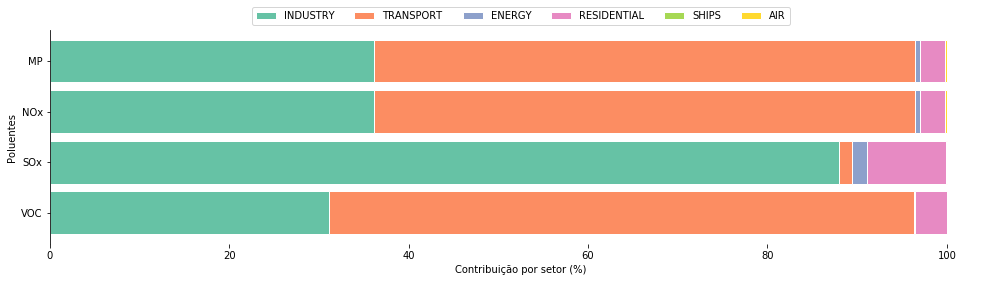

In [17]:
rows = ['VOC','SOx','NOx','MP']
emidic = {}
for m in range(0,len(mods)):
    emidic[modelagens[m]] = [float(mods[m][rows[0]].sum()),
                             float(mods[m][rows[1]].sum()),
                             float(mods[m][rows[2]].sum()),
                             float(mods[m][rows[3]].sum())]
emidic['Pol'] = rows
emidf = pd.DataFrame(emidic)
emidf.set_index('Pol', inplace=True)

totals = [i+j+k+a+b+c for i,j,k,a,b,c in zip(emidf[modelagens[1]], emidf[modelagens[2]], emidf[modelagens[3]],
                                             emidf[modelagens[4]],emidf[modelagens[5]],emidf[modelagens[6]])]
AIR = [i / j * 100 for i,j in zip(emidf['AIR'], totals)]
INDUSTRY = [i / j * 100 for i,j in zip(emidf['INDUSTRY'], totals)]
ENERGY = [i / j * 100 for i,j in zip(emidf['ENERGY'], totals)]
RESIDENTIAL = [i / j * 100 for i,j in zip(emidf['RESIDENTIAL'], totals)]
SHIPS = [i / j * 100 for i,j in zip(emidf['SHIPS'], totals)]
TRANSPORT = [i / j * 100 for i,j in zip(emidf['TRANSPORT'], totals)]
r = [0,1,2,3]

fig, ax = plt.subplots(figsize=(14,4), frameon=False)
# plot
barWidth = 0.85
# Create INDUSTRY
ax.barh(r, INDUSTRY, color=clset[0], edgecolor='white', 
        height=barWidth, label='INDUSTRY')
# Create TRANSPORT
ax.barh(r, TRANSPORT, left=INDUSTRY, color=clset[1], edgecolor='white', 
        height=barWidth, label='TRANSPORT')
# Create ENERGY
ax.barh(r, ENERGY, left=[i+j for i,j in zip(INDUSTRY,TRANSPORT)], color=clset[2], edgecolor='white', 
        height=barWidth, label='ENERGY')
# Create RESIDENTIAL
ax.barh(r, RESIDENTIAL, left=[i+j+k for i,j,k in zip(INDUSTRY,TRANSPORT,ENERGY)], color=clset[3], edgecolor='white', 
        height=barWidth, label='RESIDENTIAL')
# Create SHIPS
ax.barh(r, SHIPS, left=[i+j+k+a for i,j,k,a in zip(INDUSTRY,TRANSPORT,ENERGY,RESIDENTIAL)], color=clset[4], edgecolor='white', 
        height=barWidth, label='SHIPS')
# Create AIR
ax.barh(r, AIR, left=[i+j+k+a+b for i,j,k,a,b in zip(INDUSTRY,TRANSPORT,ENERGY,RESIDENTIAL,SHIPS)], color=clset[5], edgecolor='white', 
        height=barWidth, label='AIR')
    
# Custom x axis
plt.yticks(r, rows)
ax.set_ylabel('Poluentes')
ax.set_xlabel('Contribuição por setor (%)')

# Add a legend
plt.legend(loc='lower center', bbox_to_anchor=(0.5,1), ncol=6)
plt.tight_layout(pad=1.0)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Show graphic
plt.show()

